#Import Modules

In [2]:
!pip install keras_spiking
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [31]:
import joblib
import pickle
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import glorot_uniform, HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Activation, BatchNormalization,
    Conv2D, MaxPool2D, Input, Concatenate
)
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from keras_spiking import SpikingActivation
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

#Read and Process Data

In [5]:
df = pd.read_pickle("/content/drive/MyDrive/FingerClassification/Data/data_final1.pkl")

In [6]:
len(df)

95571

In [7]:
#Sort
df = df.sort_values(by='Timestamp', ascending=True)

In [10]:
#Làm phẳng mỗi mảng 2 chiều và tạo mảng 2 chiều cho việc scale
X_flattened = np.array([blob.flatten() for blob in df['Resized_Blobs'].values])

#Normalization
min_max_scaler = MinMaxScaler()

X_min_max_scaled = min_max_scaler.fit_transform(X_flattened)
df['New'] = list(X_min_max_scaled)

area_scaled = min_max_scaler.fit_transform(df['Area'].values.reshape(-1, 1))
df['Area'] = area_scaled

In [ ]:
# Special Cases
df['Finger_Categorys'] = df['Finger'].replace({'little': 'Others', 'ring': 'Others', 'index': 'Others', 'middle': 'Others', 'thumb': 'Thumb'})
df['Finger_Categorys'] = df['Finger'] + "_" + df['Handedness']

In [11]:
#Split Data
split_factor = 0.8
ptcp_train = df.Participant.unique()[:math.floor(len(df.Participant.unique())*split_factor)]
ptcp_test = df.Participant.unique()[math.floor(len(df.Participant.unique())*split_factor):]
df_train = df[df.Participant.isin(ptcp_train)].copy(deep=True)
df_test = df[df.Participant.isin(ptcp_test)].copy(deep=True)

In [12]:
le = LabelEncoder()

X_train = np.stack(df_train[['New', 'Area']].values)
X_test = np.stack(df_test[['New', 'Area']].values)

X_train_features = np.array([sample[0] for sample in X_train])
X_train_area = np.array([sample[1] for sample in X_train])

X_test_features = np.array([sample[0] for sample in X_test])
X_test_area = np.array([sample[1] for sample in X_test])

In [17]:
#Set params
n_steps = 5
dt = 0.3

In [14]:
X_train_area = X_train_area.reshape(-1, 1)
X_test_area = X_test_area.reshape(-1, 1)

In [18]:
X_train_features = np.tile(X_train_features[:, None, :], (1, n_steps, 1))
X_train_area = np.tile(X_train_area[:, None], (1, n_steps, 1))

X_test_features = np.tile(X_test_features[:, None, :], (1, n_steps, 1))
X_test_area = np.tile(X_test_area[:, None], (1, n_steps, 1))

In [25]:
#Encode
y_train = df_train['Handedness'].values
y_test = df_test['Handedness'].values
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

#One-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

#Build SNN Model

In [42]:
#Blobs 8x8
input_64 = tf.keras.Input(shape=(n_steps, 64))
#Ellipse Area
input_1 = tf.keras.Input(shape=(n_steps, 1))

# Feature 1
x1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_64)
x1 = keras_spiking.SpikingActivation("relu", dt = dt, spiking_aware_training=True)(x1)

# Feature 2
x2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_1)
x2 = keras_spiking.SpikingActivation("relu", dt = dt, spiking_aware_training=True)(x2)

#Merge input
merged = tf.keras.layers.Concatenate(axis=-1)([x1, x2])

# Next layers
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64))(merged)
x = keras_spiking.SpikingActivation("relu", dt = dt, spiking_aware_training=True)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32))(x)
x = keras_spiking.SpikingActivation("relu", dt = dt, spiking_aware_training=True)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16))(x)
x = keras_spiking.SpikingActivation("relu", dt = dt, spiking_aware_training=True)(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
output = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_64, input_1], outputs=output)
#Check model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 5, 64)]              0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 time_distributed_15 (TimeD  (None, 5, 128)               8320      ['input_7[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_16 (TimeD  (None, 5, 128)               256       ['input_8[0][0]']       

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#Training

In [48]:
checkpoint = ModelCheckpoint('/content/SNN_0.3.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
history = model.fit(
    [X_train_features, X_train_area], y_train_one_hot,
    validation_data=([X_test_features, X_test_area], y_test_one_hot),
    epochs=70,
    batch_size = 16,
    callbacks=[checkpoint]
)


Epoch 1/70
4734/4734 [==============================] - 36s 7ms/step - loss: 0.6257 - categorical_accuracy: 0.6398 - val_loss: 0.5491 - val_categorical_accuracy: 0.7172
Epoch 2/70
4734/4734 [==============================] - 30s 6ms/step - loss: 0.5341 - categorical_accuracy: 0.7317 - val_loss: 0.5441 - val_categorical_accuracy: 0.7266
Epoch 3/70
4734/4734 [==============================] - 29s 6ms/step - loss: 0.4996 - categorical_accuracy: 0.7549 - val_loss: 0.4945 - val_categorical_accuracy: 0.7486
Epoch 4/70
4734/4734 [==============================] - 30s 6ms/step - loss: 0.4765 - categorical_accuracy: 0.7684 - val_loss: 0.4447 - val_categorical_accuracy: 0.7854
Epoch 5/70
4734/4734 [==============================] - 31s 7ms/step - loss: 0.4589 - categorical_accuracy: 0.7796 - val_loss: 0.4323 - val_categorical_accuracy: 0.7925
Epoch 6/70
4734/4734 [==============================] - 29s 6ms/step - loss: 0.4439 - categorical_accuracy: 0.7899 - val_loss: 0.3920 - val_categorical_acc

# Visualize Traning Process

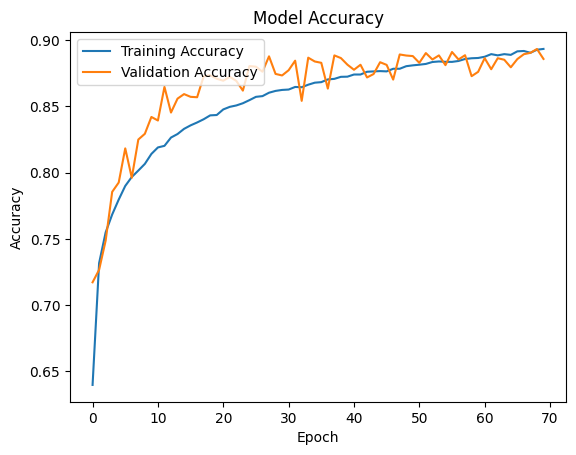

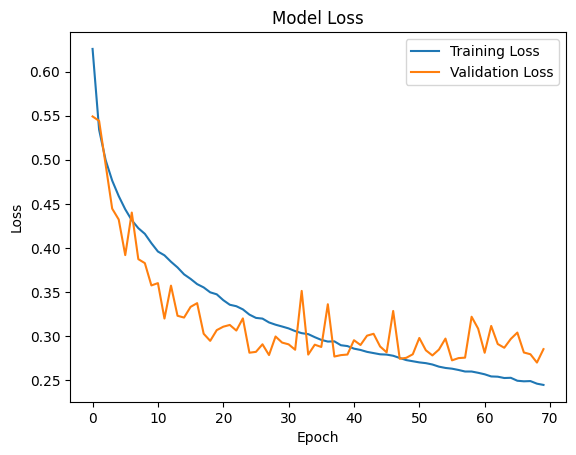

In [49]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#Evaluating

In [50]:
# Load model
snn_model = load_model('/content/SNN_0.3.h5',
                       custom_objects={'SpikingActivation': SpikingActivation})


In [52]:
from keras.metrics import CategoricalAccuracy
from keras.losses import CategoricalCrossentropy
snn_model.compile(loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

loss, accuracy = snn_model.evaluate([X_test_features, X_test_area], y_test_one_hot, verbose=1)

print(f"Best model test loss: {loss}")
print(f"Best model test accuracy: {accuracy}")

620/620 [==============================] - 9s 3ms/step - loss: 0.2711 - categorical_accuracy: 0.8922
Best model test loss: 0.2711007297039032
Best model test accuracy: 0.8921672701835632


#Visualize Neuron Spikes

In [4]:
pretrained_weights = snn_model.get_weights()

class_names = ['left', 'right']
def build_spiking_model(input_shape_64, input_shape_1, dt = 0.5):
    input_64 = tf.keras.Input(shape=input_shape_64)
    input_1 = tf.keras.Input(shape=input_shape_1)

    x1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_64)
    x1 = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True)(x1)

    x2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_1)
    x2 = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True)(x2)

    merged = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64))(merged)
    x = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True,  return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32))(x)
    x = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True,  return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16))(x)
    spike_layer = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True, return_sequences=True)(x)
    output = tf.keras.layers.Dense(2)(spike_layer)

    model = tf.keras.Model(inputs=[input_64, input_1], outputs=[output, spike_layer])
    return model

prediction_model = build_spiking_model((None, 64), (None, 1))

prediction_model.set_weights(pretrained_weights)

output, spikes = prediction_model.predict([X_test_features, X_test_area])

time = X_test_features.shape[1] * prediction_model.layers[-4].dt
n_spikes = spikes * prediction_model.layers[-4].dt
spike_rates = np.sum(n_spikes, axis = 1)/ time
print(f"Spike rate per neuron (Hz): min={spike_rates.min():.2f} mean={spike_rates.mean():.2f} max={spike_rates.max():.2f}")

# Vẽ biểu đồ
for i in range(5):  # Vẽ cho 6 mẫu dữ liệu đầu tiên
    plt.figure(figsize=(12, 4))

    # Biểu đồ input
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_features[i, 0].reshape(8, 8), cmap='gray')
    plt.title(f"Class: {class_names[actual_classes[i]]}")
    plt.axis('off')

    # Biểu đồ số spikes
    plt.subplot(1, 3, 2)
    plt.title("Spikes per neuron per timestep")
    bin_edges = np.arange(int(np.max(spikes[i])) + 2) - 0.5
    plt.hist(np.ravel(spikes[i]), bins=bin_edges)
    plt.xlabel("# of spikes")
    plt.ylabel("Frequency")

    # Biểu đồ dự đoán và nhãn dự đoán
    plt.subplot(1, 3, 3)
    plt.title("Output predictions")
    softmax_output = tf.nn.softmax(output[i], axis=1).numpy()
    time_points = np.arange(X_test_features.shape[1]) * prediction_model.layers[-4].dt
    plt.plot(time_points, softmax_output)
    plt.xlabel("Time (s)")
    plt.ylabel("Probability")
    plt.legend(class_names, loc="upper left")
    plt.ylim([-0.05, 1.05])

    # Lấy nhãn dự đoán cuối cùng từ softmax output
    final_prediction_index = np.argmax(softmax_output[-1])
    final_prediction_label = class_names[final_prediction_index]

    # Thêm nhãn dự đoán vào biểu đồ
    plt.text(time_points[-1], softmax_output[-1, final_prediction_index],
             f'{final_prediction_label}', fontsize=12, ha='right', va='bottom')

    plt.tight_layout()
    plt.show()

NameError: name 'snn_model' is not defined

#Estimate energy consumption

In [ ]:
# In ra các thiết bị đã đăng ký và thông số của chúng
print(keras_spiking.ModelEnergy.devices)

In [ ]:
n_steps = 5
example_data = [np.ones((32, n_steps, 64)), np.ones((32, n_steps, 1))]

# Ước tính mức tiêu thụ năng lượng
energy = keras_spiking.ModelEnergy(model, example_data=example_data)

# Hiển thị mức tiêu thụ năng lượng
energy.summary(
    columns=(
        "name",
        "rate",
        "energy cpu",
        "energy gpu",
        "energy loihi",
        "energy spinnaker",
        "energy spinnaker2",
        "energy arm"
    ),
    dt = 0.3,
    timesteps_per_inference = 5,
    print_warnings=False,
)

/usr/local/lib/python3.10/dist-packages/keras_spiking/model_energy.py:773: UserWarning: Cannot compute stats for layer of type 'Concatenate'.Use `ModelEnergy.register_layer` to register this layer.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
Layer (type)    |Rate [Hz]|J/inf (cpu)|J/inf (gpu)|J/inf (loih|J/inf (spin|J/inf (spin|J/inf (arm)
----------------|---------|-----------|-----------|-----------|-----------|-----------|-----------
input_1 (InputLa|        1|          0|          0|          0|          0|          0|          0
input_2 (InputLa|        1|          0|          0|          0|          0|          0|          0
time_distributed|        1|      7e-05|    2.5e-06|    3.3e-07|    0.00016|    5.5e-06|    7.4e-06
time_distributed|        1|    1.1e-06|    3.8e-08|    5.2e-09|    2.6e-06|    8.6e-08|    1.2e-07
spiking_activati|     0.61|    1.1e-06|    3.8e-08|    5.2e-08|    1.7e-05|    1.4e-06|    1.2e-07
spiking_activati|     0.12|    1.1e-06|    3.8e-08|    5.2e-08|    1.7e-05|    1.4e-06|    1.2e-07
concatenate (Con|     0.18|          0|          0|          0|          0|          0|          0
time_distributed|     0.18|    0.00014|    4.9e-06|    1.2e

In [ ]:
example_data = [np.ones((32, 1, 64)), np.ones((32, 1, 1))]

# Ước tính mức tiêu thụ năng lượng
energy = keras_spiking.ModelEnergy(model, example_data=example_data)

# Hiển thị mức tiêu thụ năng lượng
energy.summary(
    columns=(
        "name",
        "rate",
        "energy cpu",
        "energy gpu",
        "energy loihi",
    ),
    timesteps_per_inference=5,
    dt = 2,
    print_warnings=False,
)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_58" is incompatible with the layer: expected shape=(None, 10, 64), found shape=(32, 1, 64)


In [ ]:
energy.summary(
    columns=(
        "name",
        "energy cpu",
        "energy gpu",
        "synop_energy cpu",
        "synop_energy gpu",
        "neuron_energy cpu",
        "neuron_energy gpu",
    ),
    print_warnings=False,
)


Layer (type)      |J/inf (cpu)|J/inf (gpu)|Synop J/inf (|Synop J/inf (|Neuron J/inf |Neuron J/inf 
------------------|-----------|-----------|-------------|-------------|-------------|-------------
input_1 (InputLaye|          0|          0|            0|            0|            0|            0
input_2 (InputLaye|          0|          0|            0|            0|            0|            0
time_distributed (|      7e-05|    2.5e-06|        7e-05|      2.5e-06|            0|            0
time_distributed_1|    1.1e-06|    3.8e-08|      1.1e-06|      3.8e-08|            0|            0
spiking_activation|    1.1e-06|    3.8e-08|            0|            0|      1.1e-06|      3.8e-08
spiking_activation|    1.1e-06|    3.8e-08|            0|            0|      1.1e-06|      3.8e-08
concatenate (Conca|          0|          0|            0|            0|            0|            0
time_distributed_2|    0.00014|    4.9e-06|      0.00014|      4.9e-06|            0|            0
spiking_ac

In [ ]:
import os
import psutil

# Kiểm tra loại CPU
cpu_info = !lscpu
cpu_info = "\n".join(cpu_info)
print("CPU Info:\n", cpu_info)

# Kiểm tra số lượng nhân và luồng
print("Số nhân vật lý:", psutil.cpu_count(logical=False))
print("Số luồng:", psutil.cpu_count(logical=True))

# Kiểm tra dung lượng RAM
print("Dung lượng RAM:", psutil.virtual_memory().total / (1024**3), "GB")


CPU Info:
 Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dno